In [1]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
#     Maurice F. Huguenin, m.huguenin-virchaux@unsw.edu.au, 26. 01. 2024      #                                                
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
# % preamble ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #   
base = '/g/data/e14/mv7494/access-om2/archive/025deg_jra55_iaf/'
save = '/home/561/mv7494/ENSOAnt_figures/'

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cf_xarray
import cartopy.crs as ccrs
import cmocean as cm
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)
from dask.distributed import Client
import matplotlib.path as mpath
import scipy as sp
import scipy.interpolate
import scipy.ndimage
import scipy.io
import scipy.stats
import string # for subplot annotation
import pandas as pd
from pandas import DataFrame
import cartopy.feature as cft
from metpy.interpolate import cross_section
from pathlib import Path
import xgcm
from pyproj import Proj, transform
import datetime
import gsw
rotblau = [[0.4 , 0.  , 0.12], [0.47, 0.02, 0.13], [0.62, 0.07, 0.16], [0.66, 0.16, 0.2],
           [0.8 , 0.3 , 0.27], [0.87, 0.44, 0.35], [0.93, 0.58, 0.45], [0.96, 0.7 , 0.58], 
           [0.98, 0.8 , 0.71], [0.98, 0.94, 0.92], [0.93, 0.95, 0.96], [0.85, 0.91, 0.95],
           [0.76, 0.87, 0.93], [0.64, 0.8 , 0.89], [0.49, 0.72, 0.84], [0.34, 0.62, 0.79], 
           [0.23, 0.53, 0.74], [0.16, 0.44, 0.7] , [0.1 ,0.35, 0.6], [0.05, 0.24, 0.45], [0.02, 0.19, 0.38]]

In [2]:
client = Client(n_workers=8)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 8
Total threads: 16,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45641,Workers: 8
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:33527,Total threads: 2
Dashboard: /proxy/41963/status,Memory: 31.25 GiB
Nanny: tcp://127.0.0.1:44729,


In [3]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

In [4]:
# This one is probably the most important function. Could check if it can be simplified and / or if there is a function available in a module that does the same. 

def lagcorr(x,y,lag=None,verbose=True):
    '''Compute lead-lag correlations between 2 time series.

    <x>,<y>: 1-D time series.
    <lag>: lag option, could take different forms of <lag>:
          if 0 or None, compute ordinary correlation and p-value;
          if positive integer, compute lagged correlation with lag
          upto <lag>;
          if negative integer, compute lead correlation with lead
          upto <-lag>;
          if pass in an list or tuple or array of integers, compute 
          lead/lag correlations at different leads/lags.

    Note: when talking about lead/lag, uses <y> as a reference.
    Therefore positive lag means <x> lags <y> by <lag>, computation is
    done by shifting <x> to the left hand side by <lag> with respect to
    <y>.
    Similarly negative lag means <x> leads <y> by <lag>, computation is
    done by shifting <x> to the right hand side by <lag> with respect to
    <y>.

    Return <result>: a (n*2) array, with 1st column the correlation 
    coefficients, 2nd column correpsonding p values.

    Currently only works for 1-D arrays.
    '''

    import numpy
    from scipy.stats import pearsonr

    if len(x)!=len(y):
        raise('Input variables of different lengths.')

    #--------Unify types of <lag>-------------
    if numpy.isscalar(lag):
        if abs(lag)>=len(x):
            raise('Maximum lag equal or larger than array.')
        if lag<0:
            lag=-numpy.arange(abs(lag)+1)
        elif lag==0:
            lag=[0,]
        else:
            lag=numpy.arange(lag+1)    
    elif lag is None:
        lag=[0,]
    else:
        lag=numpy.asarray(lag)

    #-------Loop over lags---------------------
    result=[]
    if verbose:
        print('\n#<lagcorr>: Computing lagged-correlations at lags:',lag)

    for ii in lag:
        if ii<0:
            result.append(pearsonr(x[:ii],y[-ii:]))
        elif ii==0:
            result.append(pearsonr(x,y))
        elif ii>0:
            result.append(pearsonr(x[ii:],y[:-ii]))

    result=numpy.asarray(result)

    return result

In [5]:
def make_movie(instr, outstr):
    import glob 
    import cv2

    img_array = []
    for filename in glob.glob(instr):
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width,height)
        img_array.append(img)

    out = cv2.VideoWriter(outstr,cv2.VideoWriter_fourcc(*'DIVX'), 2, size)
 
    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()

In [6]:
geolon_t = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolon_t
geolat_t = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolat_t

In [7]:
def make_boundary_path(longitudes, latitudes):
    """
    Return a path around boundary to create a sector map, then cut it out given
    longitudes and latitudes.
    """
    boundary_path = np.array([longitudes[-1, :], latitudes[-1, :]])
    boundary_path = np.append(boundary_path, np.array([longitudes[::-1, -1], latitudes[::-1, -1]]), axis=1)
    boundary_path = np.append(boundary_path, np.array([longitudes[1, ::-1],  latitudes[1, ::-1]]), axis=1)
    boundary_path = np.append(boundary_path, np.array([longitudes[:, 1],     latitudes[:, 1]]), axis=1)
    boundary_path = mpath.Path(np.swapaxes(boundary_path, 0, 1))

    return boundary_path

In [8]:
# Define sector maps 
# West Antarctica:
midlon = -100
maxlon = -40
minlon = -160
minlat = -80
maxlat = -60
midlat = (minlat + maxlat)/2
lons = geolon_t.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)})
lats = geolat_t.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)})
boundary_path_wa = make_boundary_path(lons, lats)
extent_wa = [minlon,maxlon,minlat,maxlat]
projection_wa=ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)

# Amundsen Sea
midlon = -105
maxlon = -85
minlon = -125
minlat = -78
maxlat = -68
midlat = (minlat + maxlat)/2
lons = geolon_t.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)})
lats = geolat_t.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)})
boundary_path_am = make_boundary_path(lons, lats)
extent_am = [minlon,maxlon,minlat,maxlat]
projection_am = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)

# Amundsen Sea large
midlon = -105
maxlon = -75
minlon = -135
minlat = -78
maxlat = -65
midlat = (minlat + maxlat)/2
lons = geolon_t.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)})
lats = geolat_t.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)})
boundary_path_aml = make_boundary_path(lons, lats)
extent_aml = [minlon,maxlon,minlat,maxlat]
projection_aml = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)

# Amundsen Sea coastal
midlon = -105
maxlon = -75
minlon = -135
minlat = -77
maxlat = -70
midlat = (minlat + maxlat)/2
lons = geolon_t.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)})
lats = geolat_t.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)})
boundary_path_amc = make_boundary_path(lons, lats)
extent_amc = [minlon,maxlon,minlat,maxlat]
projection_amc = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)

# Pine Island Bay
midlon = -105
maxlon = -98
minlon = -115
minlat = -76
maxlat = -71.7
midlat = (minlat + maxlat)/2
lons = geolon_t.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)})
lats = geolat_t.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)})
boundary_path_pib = make_boundary_path(lons, lats)
extent_pib = [minlon,maxlon,minlat,maxlat]
projection_pib = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)

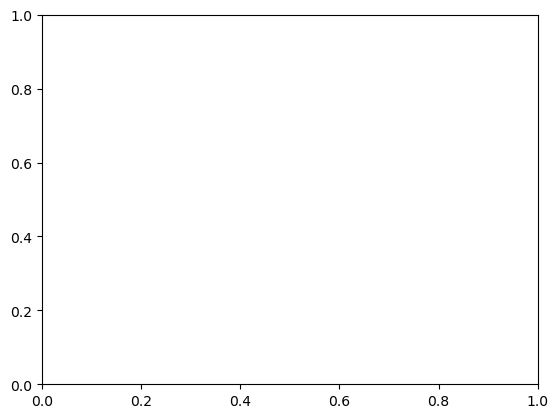

In [9]:
def spatial_plot(pattern, levels = None, cell='u', ax=plt.gca(), sect = 'am', cmap = cm.cm.balance, extend='both'):
    if sect == 'am':
        extent = extent_am
        boundary_path = boundary_path_am
    elif sect == 'wa':
        extent = extent_wa
        boundary_path = boundary_path_wa
    elif sect == 'aml':
        extent = extent_aml
        boundary_path = boundary_path_aml
    elif sect == 'amc':
        extent = extent_amc
        boundary_path = boundary_path_amc
    elif sect == 'pib':
        extent = extent_pib
        boundary_path = boundary_path_pib
    if levels == 'None':
        levels = np.linspace(-np.nanmax(abs(pattern)), 1.1*np.nanmax(abs(pattern)),21)
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
    ax.coastlines(resolution='50m')
    ax.gridlines()
    ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
    if cell == 'u':
        p1 = pattern.plot.contourf(ax=ax,
                    x='xu_ocean', y='yu_ocean', levels = levels, add_colorbar = False, cmap=cmap, extend=extend,
                    transform=ccrs.PlateCarree())
    elif cell == 't':
        p1 = pattern.plot.contourf(ax=ax,
                    x='xt_ocean', y='yt_ocean', levels = levels, add_colorbar = False, cmap=cmap, extend=extend,
                    transform=ccrs.PlateCarree())
    p2 = ht.plot.contour(ax=ax,
                   x='xt_ocean', y='yt_ocean', levels=[1000], colors='k',linewidth=1,
                   transform=ccrs.PlateCarree())
    return p1, p2

In [10]:
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                   edgecolor='black', facecolor='gray', linewidth=0.5)
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [11]:
# Load mooring data. Position roughly: 102W,75.05S
mo_data = scipy.io.loadmat('/g/data/e14/mv7494/NBP0901_mooring_data/BSR5_am_eisschelf_pine_island.mat')
mo_data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Mon Feb 17 19:42:52 2014',
 '__version__': '1.0',
 '__globals__': [],
 'bsr5': array([[(array([[-101.05593333]]), array([[-75.05593333]]), array([[47.74214938]]), array([[(array([[733795.39585022],
                        [733795.4062669 ],
                        [733795.41668357],
                        ...,
                        [735645.69898033],
                        [735645.709397  ],
                        [735645.71981368]]), array([[1.2093],
                        [1.2095],
                        [1.2095],
                        ...,
                        [1.0874],
                        [1.0946],
                        [1.0963]]), array([[30.197949],
                        [30.200251],
                        [30.200487],
                        ...,
                        [29.928134],
                        [29.931016],
                        [29.934015]]), array([[792.764],
                 

In [12]:
data = mo_data['bsr5'] # Has data for several instruments (different depths) over 5 years 
time1 = pd.to_datetime(data[0][0][3][0][0][0][:,0]-719529, unit='D')
temp1 = data[0][0][3][0][0][1][:,0]
cond1 = data[0][0][3][0][0][2][:,0]
pres1 = data[0][0][3][0][0][3][:,0]
dept1 = data[0][0][3][0][0][4][:,0]
#mo1 = np.concatenate((time1,temp1,dept1),axis=1)
# The gsw module has several functions for converting different units. We will use it to convert from in-situ temperature (moorings) to conservative temperature (model).
# Needs absolute salinity as input. We could calculate that from conductivity for some moorings but it does not matter much so we just use 35 for now. 
ct1 = gsw.conversions.CT_from_t(35,temp1,pres1) 
sp1 = gsw.conversions.SP_from_C(cond1,temp1,pres1)
sa1 = gsw.conversions.SA_from_SP(sp1,pres1,-102,-75)

In [13]:
time2 = pd.to_datetime(data[0][0][4][0][0][0][:,0]-719529, unit='D')
temp2 = data[0][0][4][0][0][1][:,0]
cond2 = data[0][0][4][0][0][2][:,0]
pres2 = data[0][0][4][0][0][3][:,0]
dept2 = data[0][0][4][0][0][4][:,0]
ct2 = gsw.conversions.CT_from_t(35,temp2,pres2)
sp2 = gsw.conversions.SP_from_C(cond2,temp2,pres2)
sa2 = gsw.conversions.SA_from_SP(sp2,pres2,-102,-75)
time3 = pd.to_datetime(data[0][0][5][0][0][0][:,0]-719529, unit='D')
temp3 = data[0][0][5][0][0][1][:,0]
pres3 = data[0][0][5][0][0][2][:,0]
dept3 = data[0][0][5][0][0][3][:,0] # here index 3 is depth
ct3 = gsw.conversions.CT_from_t(35,temp3,pres3)
time4 = pd.to_datetime(data[0][0][6][0][0][0][:,0]-719529, unit='D')
temp4 = data[0][0][6][0][0][1][:,0]
pres4 = data[0][0][6][0][0][2][:,0]
dept4 = data[0][0][6][0][0][3][:,0]
ct4 = gsw.conversions.CT_from_t(35,temp4,pres4)
time5 = pd.to_datetime(data[0][0][7][0][0][0][:,0]-719529, unit='D')
temp5 = data[0][0][7][0][0][1][:,0]
pres5 = data[0][0][7][0][0][2][:,0]
dept5 = data[0][0][7][0][0][3][:,0]
ct5 = gsw.conversions.CT_from_t(35,temp5,pres5)

In [14]:
# create xr datasets for monthly means
mo_xr_1 = xr.Dataset({'T':("time",temp1),'CT':("time",ct1),'SA':("time",sa1),'d':("time",dept1),"time":time1})
mo_xr_mon_1 = mo_xr_1.resample({'time':'M'}).mean('time')

mo_xr_2 = xr.Dataset({'T':("time",temp2),'CT':("time",ct2),'SA':("time",sa2),'d':("time",dept2),"time":time2})
mo_xr_mon_2 = mo_xr_2.resample({'time':'M'}).mean('time')

mo_xr_3 = xr.Dataset({'T':("time",temp3),'CT':("time",ct3),'d':("time",dept3),"time":time3})
mo_xr_mon_3 = mo_xr_3.resample({'time':'M'}).mean('time')

mo_xr_4 = xr.Dataset({'T':("time",temp4),'CT':("time",ct4),'d':("time",dept4),"time":time4})
mo_xr_mon_4 = mo_xr_4.resample({'time':'M'}).mean('time')

mo_xr_5 = xr.Dataset({'T':("time",temp5),'CT':("time",ct5),'d':("time",dept5),"time":time5})
mo_xr_mon_5 = mo_xr_5.resample({'time':'M'}).mean('time')

Text(0, 0.5, 'Salinity')

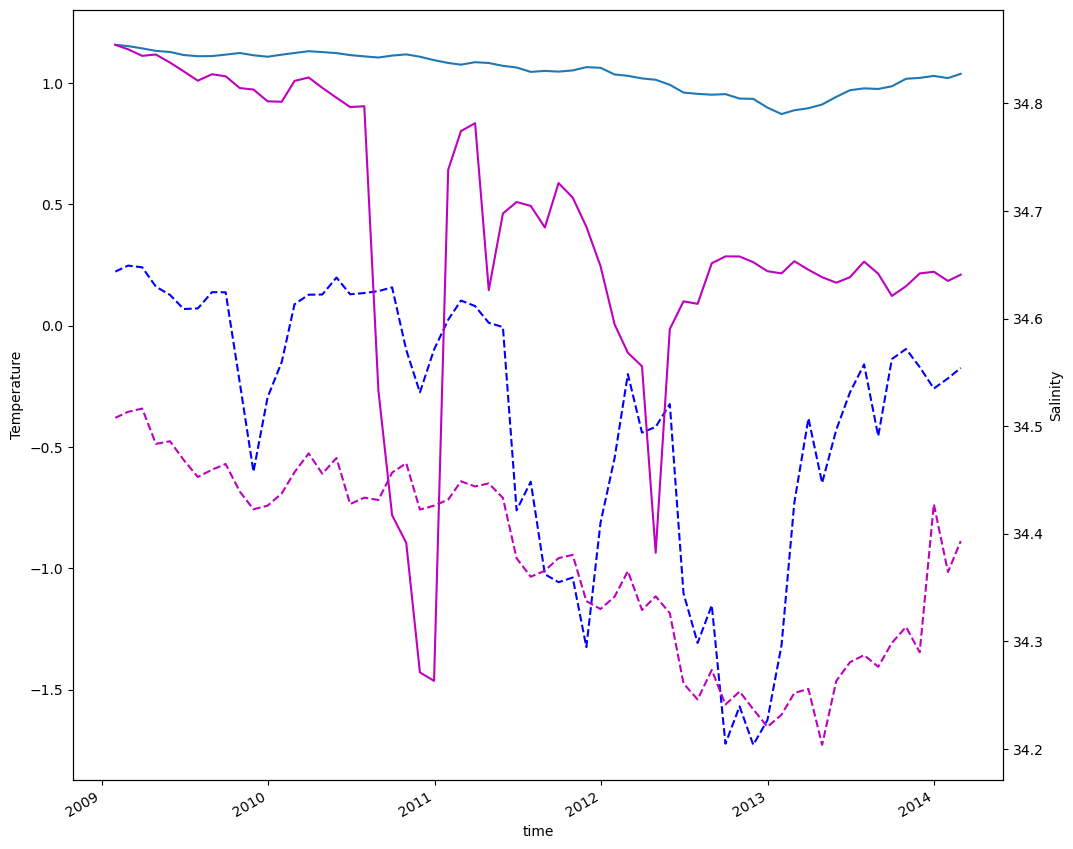

In [15]:
fig, ax =plt.subplots(1,1,figsize=(12,10))
mo_xr_mon_1.CT.plot(ax = ax)
axb= ax.twinx()
mo_xr_mon_1.SA.plot(ax=axb, color='m')
mo_xr_mon_2.CT.plot(ax=ax,color='b',ls='--')
mo_xr_mon_2.SA.plot(ax=axb,color='m',ls='--')
ax.set_ylabel('Temperature')
axb.set_ylabel('Salinity')

In [16]:
mo_xr_mon_1

<xarray.Dataset>
Dimensions:  (time: 62)
Coordinates:
  * time     (time) datetime64[ns] 2009-01-31 2009-02-28 ... 2014-02-28
Data variables:
    T        (time) float64 1.199 1.194 1.185 1.174 ... 1.062 1.07 1.061 1.079
    CT       (time) float64 1.157 1.152 1.143 1.133 ... 1.021 1.029 1.02 1.038
    SA       (time) float64 34.85 34.85 34.84 34.85 ... 34.64 34.64 34.64 34.64
    d        (time) float64 783.0 783.0 783.0 783.1 ... 783.0 783.0 783.0 783.0

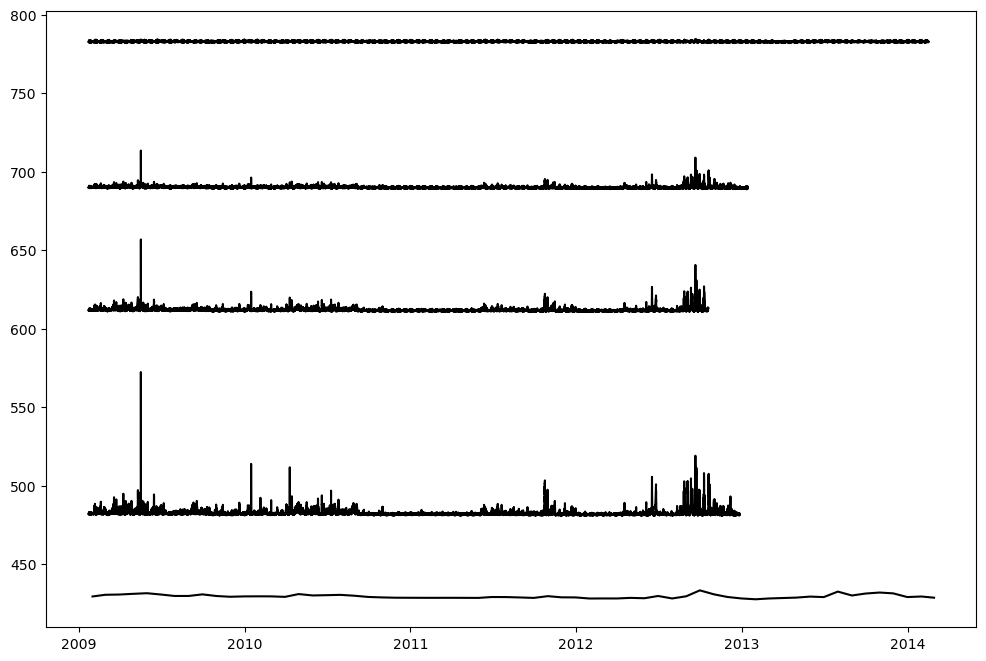

In [17]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.plot(time1,dept1,'k')
ax.plot(mo_xr_mon_2.time,mo_xr_mon_2.d,'k')
ax.plot(time3,dept3,'k')
ax.plot(time4,dept4,'k')
ax.plot(time5,dept5,'k')

In [18]:
# load ocean temperature from model 
experiment = '01deg_jra55v140_iaf_cycle2'
start = '2009-01-01 00:00:00' # start date, from 2009
end = '2019-01-01 00:00:00' # end date


t = cc.querying.getvar(experiment, 'temp', session,
                       start_time=start, end_time=end).sel(yt_ocean=slice(-77,-72)).sel(xt_ocean=slice(-115,-95)).sel(st_ocean=slice(0,1000))
area_t = cc.querying.getvar(experiment,'area_t',session, n=-1).sel(yt_ocean=slice(-77,-72)).sel(xt_ocean=slice(-115,-95)).fillna(1.0).astype(int) - 1
area_t.load()
ht = cc.querying.getvar(experiment, 'ht', session, n=1).sel(yt_ocean=slice(-77,-72)).sel(xt_ocean=slice(-115,-95)).load()
t

<xarray.DataArray 'temp' (time: 123, st_ocean: 46, yt_ocean: 118, xt_ocean: 200)>
dask.array<getitem, shape=(123, 46, 118, 200), dtype=float32, chunksize=(1, 19, 81, 150), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -115.0 -114.9 -114.8 ... -95.25 -95.15 -95.05
  * yt_ocean  (yt_ocean) float64 -76.97 -76.93 -76.88 ... -72.11 -72.07 -72.03
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 4.332 ... 766.1 843.0 926.6
  * time      (time) datetime64[ns] 2008-10-16T12:00:00 ... 2018-12-16T12:00:00
Attributes: (12/13)
    long_name:      Conservative temperature
    units:          K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t
    ...             ...
    ncfiles:        ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_...
    contact:        Andrew Kiss
    email:          andrew.kiss@anu.edu.au
    created:        2020-08-20
    description:    0.1 degree ACCESS-OM2 global model configuration under in...
    notes:          Run configuration and history: https://github.com/COSIMA/...

In [19]:
t_model = t.load()-273.15

In [20]:
latoff = .1
lonoff = .2

lonw = -102.05 - lonoff
lone = -101.95 + lonoff
lats = -75.04 - latoff
latn = -74.99 + latoff
print(t_model.sel(yt_ocean = slice(lats,latn)).sel(xt_ocean = slice(lonw,lone)).shape[-2:])
t_model_mooring = t_model.sel(yt_ocean = slice(lats,latn)).sel(xt_ocean = slice(lonw,lone)).weighted(area_t).mean(dim=('xt_ocean','yt_ocean')).resample({'time':'M'}).mean('time')
t_model_mooring

(6, 5)


<xarray.DataArray 'temp' (time: 123, st_ocean: 46)>
array([[-1.75034018, -1.74501688, -1.73483272, ...,  0.66526698,
         0.65468561,  0.64454283],
       [-1.57857515, -1.56108717, -1.54258813, ...,  0.68174199,
         0.66702668,  0.65419541],
       [-0.56118568, -0.58324781, -0.60415591, ...,  0.70819954,
         0.68804279,  0.66985381],
       ...,
       [-1.70872306, -1.70590366, -1.70065642, ...,  0.57506228,
         0.58034149,  0.58079211],
       [-1.60908046, -1.59887433, -1.58640466, ...,  0.59579179,
         0.60251803,  0.60215822],
       [-0.33962962, -0.34988273, -0.36738179, ...,  0.6060663 ,
         0.61366642,  0.61463089]])
Coordinates:
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 4.332 ... 766.1 843.0 926.6
  * time      (time) datetime64[ns] 2008-10-31 2008-11-30 ... 2018-12-31

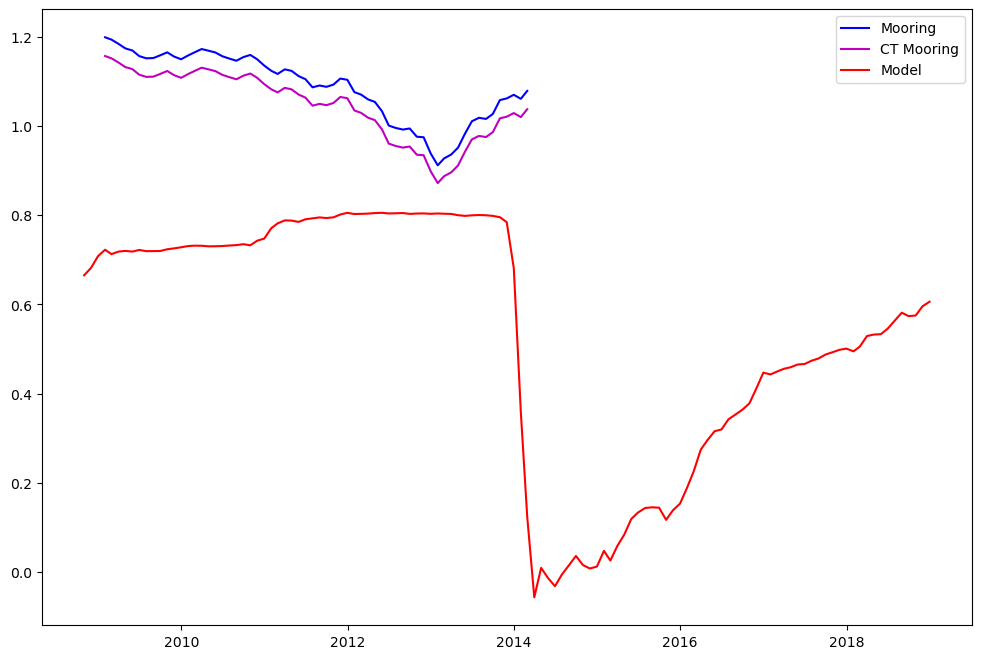

In [21]:
# Make simple comparison plots for each instrument
depth = [429,482,612,690,782]
instr = [2,5,4,3,1] # instruments ordered from top to bottom
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.plot(mo_xr_mon_1.time,mo_xr_mon_1.T,'b',label='Mooring')
ax.plot(mo_xr_mon_1.time,mo_xr_mon_1.CT,'m',label='CT Mooring')
ax.plot(t_model_mooring.time,t_model_mooring.sel(st_ocean=depth[4],method='nearest'),'r',label='Model')
ax.legend()

In [22]:
ts = '2009-01-15'
te = '2013-01-31'
r = 3
c = 1
l = lagcorr(mo_xr_mon_2.T.sel(time=slice(ts,te)).rolling(time=r, center=True).mean()[c:-c], t_model_mooring.sel(st_ocean=429,method='nearest').sel(time=slice(ts,te)).rolling(time=r, center=True).mean()[c:-c] , lag=12) # correlation to basal melting PIB
l


#<lagcorr>: Computing lagged-correlations at lags: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]


array([[0.21276174, 0.15104715],
       [0.13284578, 0.37879554],
       [0.06961394, 0.64954421],
       [0.04325368, 0.78041122],
       [0.08305677, 0.59645372],
       [0.19358661, 0.21930313],
       [0.35214439, 0.02394803],
       [0.46318279, 0.00261424],
       [0.49464073, 0.00136972],
       [0.46477139, 0.00328379],
       [0.40347744, 0.01327494],
       [0.32215439, 0.05534666],
       [0.15720891, 0.36710502]])

### Plotting time-mean data

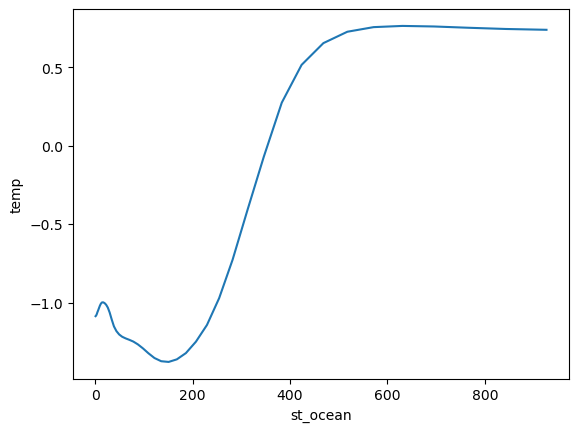

In [23]:
t_model_mooring[3:65].mean('time').plot()

CPU times: user 446 ms, sys: 49.9 ms, total: 496 ms
Wall time: 441 ms


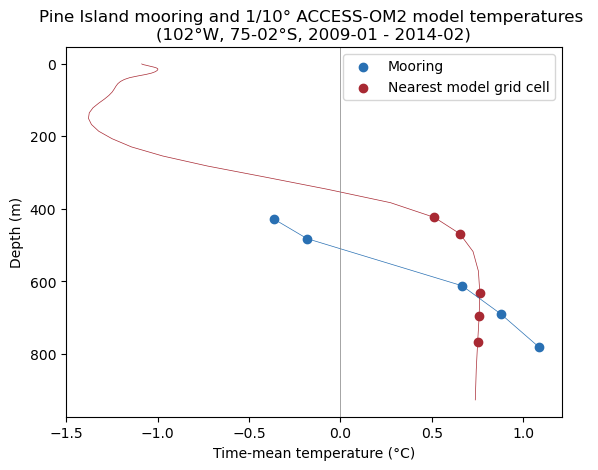

In [24]:
%%time
plt.scatter(mo_xr_mon_2.T.mean('time').values, 429, label = 'Mooring', c = rotblau[17])
plt.scatter(mo_xr_mon_5.T.mean('time').values, 482, c = rotblau[17])
plt.scatter(mo_xr_mon_4.T.mean('time').values, 612, c = rotblau[17])
plt.scatter(mo_xr_mon_3.T.mean('time').values, 690, c = rotblau[17])
plt.scatter(mo_xr_mon_1.T.mean('time').values, 782, c = rotblau[17])
mooring_depth = [429, 482, 612, 690, 782]
mooring_temps = [mo_xr_mon_2.T.mean('time').values,
                mo_xr_mon_5.T.mean('time').values,
                mo_xr_mon_4.T.mean('time').values,
                mo_xr_mon_3.T.mean('time').values,
                mo_xr_mon_1.T.mean('time').values]
plt.plot(mooring_temps, mooring_depth, c=rotblau[17], lw=.5) # line connecting all the scatter points

model_depth = np.zeros(5); model_temps = np.zeros(5)

for f in range(5):
    mod_pl = t_model_mooring.sel(st_ocean=depth[f],method='nearest')
    model_depth[f] = mod_pl.st_ocean.values; model_temps[f] = mod_pl[3:65].mean('time'); 
    if f == 0: 
        # select only 2009-01-31 to 2014-02-28 as in the mooring observations
        plt.scatter(mod_pl[3:65].mean('time'), mod_pl.st_ocean.values, label = 'Nearest model grid cell', c = rotblau[3])
    else:
        plt.scatter(mod_pl[3:65].mean('time'), mod_pl.st_ocean.values, c = rotblau[3])
# plt.plot(model_temps, model_depth, c=rotblau[3], lw=.5) # line connecting all the scatter points
plt.plot(t_model_mooring[3:65].mean('time'), t_model_mooring.st_ocean, c=rotblau[3], lw=.5) # line connecting all the scatter points

plt.gca().invert_yaxis(); plt.axvline(0, lw=.5, c='grey')
plt.legend(); plt.xlabel('Time-mean temperature (°C)'); plt.ylabel('Depth (m)')
plt.title('Pine Island mooring and 1/10° ACCESS-OM2 model temperatures \n(102°W, 75-02°S, 2009-01 - 2014-02)')
# --- saving as 300 dpi .PNG image in specified folder ------------- #
plt.savefig(save + 'Model_evaluation_with_mooring_data_at_Pine_Island_time-mean', 
            dpi=300, facecolor='w',                                  #
            edgecolor='w', orientation='landscape',                  #
            format=None, transparent=False, bbox_inches=None,        #
            pad_inches=0.1, metadata=None)                           #
# --- end of script ------------------------------------------------ #
# Wall time: 6.76 s
# plt.axhline(354, c='grey', lw=.5) # evaluating how much the thermocline difference is between the observational mooring and the model
# plt.axhline(510, c='grey', lw=.5)

In [ ]:
# ----------------------------------------------------------------------------------------------------------------------- #
#                                                   Notes down below                                                      #
# ----------------------------------------------------------------------------------------------------------------------- #